# Mini Project 1: The Travelling Salesman 

In this notebook, you will find the guidelines to complete your mini-project 1 on the travelling salesman problem. 


As illustrated in the lecture, simulated annealing is a probablistic approach used for finding a solution to an optimization problem. In this mini project you implement
a simulated annealing Python code applied to the Travelling Salesman Problem (TSP).

Typically, the TSP is an optimization problem that seeks to find the shortest path passing through every city exactly once. In our example the TSP path is defined to start and end in the same city (so the path is a closed loop).


### If you have issues with matplotlib, remember to type: conda activate in a terminal, before opening jupyter-notebook with command line

### before leaving the room, we ask you to ask a TA to review your codes, they will provide formative assessment and feedback on coding practices, but also on the general content of the report 


## Overview of the Mini project

In this project we will :

  0. construct the `simulated_annealing` function 
  0. write a pairwise swap move  
  0. Complete a temperature `schedule` function to define the temperature profile
  0. Use the obtained algorithm to solve the TSP on a generated map of random points
  0. Answer the open questions at the end of the notebook
  0. Extend this method to the realistic case of US capitals on a map
  


### Import the Numpy and Matplotlib modules

As we practiced in the past notebooks, we import here the relevant modules. 






In [1]:
import numpy as np  
import numpy.random as random  
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#%matplotlib inline




### List of US capitals

To base our approach on a realistic question, we use here the map services and data available from U.S. Geological Survey, National Geospatial Program.
If interested, see http://www.usgs.gov/visual-id/credit_usgs.html for further information.

We provide on KEATS both a map (map.png) and a list of the US capitals
(capitals.json). Please save those two files at the same location as this Python Notebook. 
We will make use in this notebook of a few additional modules that will help with
showing the path on the US map. 

These are not key to the understanding of the assignment, but will be helpful in plotting your results.

We start by importing the US map as an image file:


In [2]:
import json
import copy

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

map = mpimg.imread("map.png")  




We load the file "capitals.json", e.g. the list of US cities, into a list named `capitals_list` : 







In [3]:
# List of 30 US state capitals and corresponding coordinates on the map

with open('capitals.json', 'r') as capitals_file:
    capitals = json.load(capitals_file)
    
    
capitals_list = list(capitals.items())

capitals_list = [(c[0], tuple(c[1])) for c in capitals_list]


print(capitals_list)

print("example : ")

print(capitals_list[0])


[('Oklahoma City', (392.8, 356.4)), ('Montgomery', (559.6, 404.8)), ('Saint Paul', (451.6, 186.0)), ('Trenton', (698.8, 239.6)), ('Salt Lake City', (204.0, 243.2)), ('Columbus', (590.8, 263.2)), ('Austin', (389.2, 448.4)), ('Phoenix', (179.6, 371.2)), ('Hartford', (719.6, 205.2)), ('Baton Rouge', (489.6, 442.0)), ('Salem', (80.0, 139.2)), ('Little Rock', (469.2, 367.2)), ('Richmond', (673.2, 293.6)), ('Jackson', (501.6, 409.6)), ('Des Moines', (447.6, 246.0)), ('Lansing', (563.6, 216.4)), ('Denver', (293.6, 274.0)), ('Boise', (159.6, 182.8)), ('Raleigh', (662.0, 328.8)), ('Atlanta', (585.6, 376.8)), ('Madison', (500.8, 217.6)), ('Indianapolis', (548.0, 272.8)), ('Nashville', (546.4, 336.8)), ('Columbia', (632.4, 364.8)), ('Providence', (735.2, 201.2)), ('Boston', (738.4, 190.8)), ('Tallahassee', (594.8, 434.8)), ('Sacramento', (68.4, 254.0)), ('Albany', (702.0, 193.6)), ('Harrisburg', (670.8, 244.0))]
example : 
('Oklahoma City', (392.8, 356.4))





A path connecting a set of cities can be defined as a simple list of these cities:

`path = [capitals_list[0],capitals_list[1],capitals_list[4]]`

In this example, we connect the first, second and fifth cities of the list (St Paul, Little Rock,
Salt Lake City).

We now define below a function `show path` that will allow you to overlay the chosen path on the map of the USA, and test your implementation of the TSP on a realistic example.


In [4]:
def coord(path):
        """Strip the city name from each element of the path list and return
        a list of tuples containing only pairs of xy coordinates for the
        cities. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        _, coord = path
        return coord

def coords(path):
        """Strip the city name from each element of the path list and return
        a list of tuples containing only pairs of xy coordinates for the
        cities. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        _, coords = zip(*path)
        return coords
    
def show_path(path_, starting_city, w=35, h=15):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    path=coords(path_) 
    x, y = list(zip(*path))
    
    _, (x0, y0) = starting_city
    
    plt.imshow(map)
    plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])
    


As an example, we show the path defined above:




[('Oklahoma City', (392.8, 356.4)), ('Montgomery', (559.6, 404.8)), ('Salt Lake City', (204.0, 243.2))]


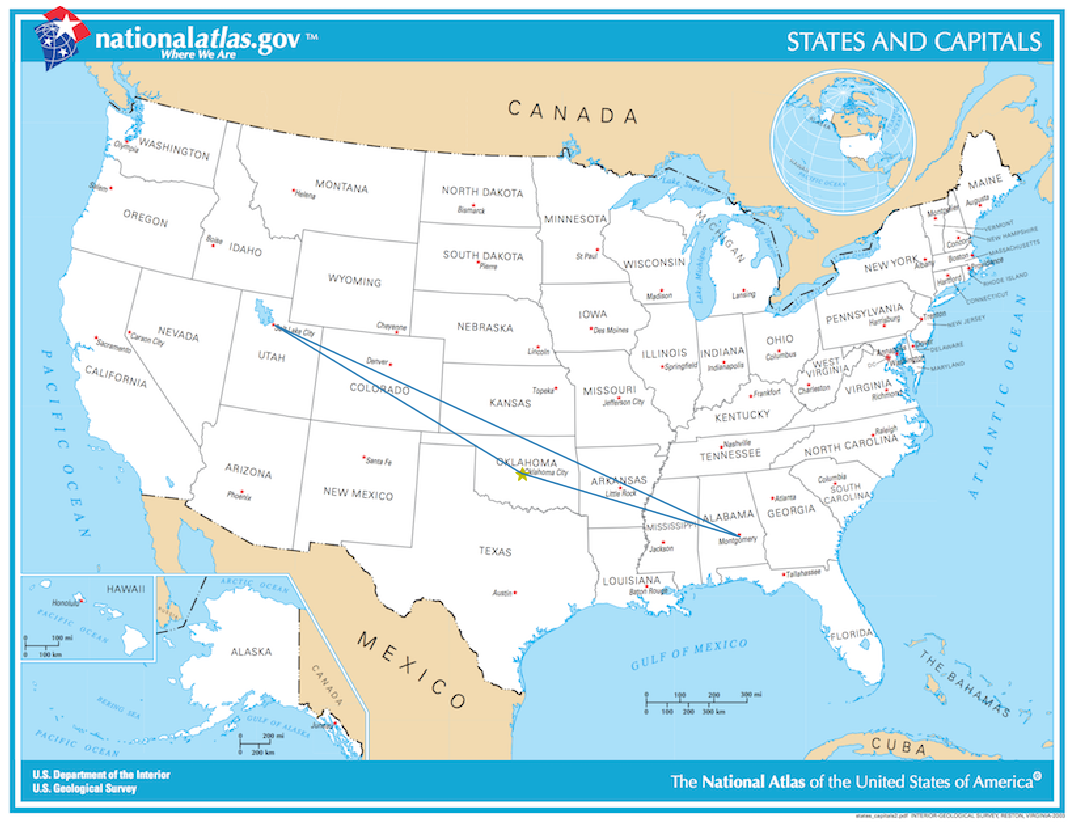

In [5]:
path = [capitals_list[0],capitals_list[1],capitals_list[4]]

print(path)

show_path(path,capitals_list[0])

## Simulated Annealing -- The algorithm

Here, we want to implement the main loop of the simulated annealing approach. 

We will repeatedly swap pairs of cities and consider accepting or rejecting such
a modification, in accordance to a probability function $P$ :

$$ P = e^{ - \left( d_{new} - d_{old}  \right) / T } $$

where $d_{new}$ and $d_{old}$ are respectively the new and old overall path length, and $T$ is a "temperature". Note of course that $T$ is not a physical temperature, but
a control parameter that determines how likely we are to accept or reject this move. 

The simulated annealing algorithm is a version of a stochastic hill climbing
where some downhill moves are allowed. Downhill moves are accepted readily
early in the annealing schedule and then less often as time goes on. 

In other terms, we will ask you to start accepting and rejecting moves with a high temperature,
and slowly reduce the temperature present in the simulation as times goes on. This is called a temperature schedule. 

The schedule input determines the value of the temperature T as a function of time. 










## Problem 1 :  Define the Temperature Schedule

The most common temperature schedule is simple exponential decay: 

$$T(t) = \alpha^t T_0$$

In most cases, the valid range for temperature $T_0$ can be very high (e.g., 1e8 or higher), and the _decay parameter_ $\alpha$ should be close to, but less than 1.0 (e.g., 0.95 or 0.99).  Think about the ways these parameters effect the simulated annealing function.  Try experimenting with both parameters to see how it changes runtime and the quality of solutions.

You can also experiment with other schedule functions -- linear, quadratic, etc.  Think about the ways that changing the form of the temperature schedule changes the behavior and results of the simulated annealing function.

In the following cell, define a function that takes the time $t$ as an argument, and returns
the temperature as an output. Use default values for the parameters $\alpha$ and $T_0$, which should also be arguments of the function.







In [6]:

def temp(t, a = .95, t_0 = 1e8):
    return (a ** t) * t_0










## Problem 2 : Define a starting random path

In order to use simulated annealing we need to build a representation of the problem domain.  The choice of representation can have a significant impact on the performance of simulated annealing and other optimization techniques.  Since the TSP deals with a close loop that visits each city in a list once, we will represent each city by a tuple containing the city name and its position specified by an (x,y) location on a grid. The path is defined as the sequence generated by traveling from each city in the list to the next in order.

Note that in the example above, `capital_cities` is a list that contains the cities, both their names and their coordinates. 

For example, a chosen path could be:

`path_start = [ capitals_list[0], capitals_list[2], capitals_list[5] ]` 

The associated geographic coordinates can be obtained by the function `coords( city_list  )`, which returns a list of the coordinates for the path, or similarly, by the function `coord( city )`, which returns the coordinates of a single city.





In [7]:
print("coordinate of the city capital_cities[2] : ")

print( coord ( capitals_list[2] ) )  


coordinate of the city capital_cities[2] : 
(451.6, 186.0)


Define in the cell below a function which generates a random path that connects 8 cities, and passes only once by each cities





In [8]:
def getPath(n=8):

    test_cities = []
    mod_capitals = list(capitals_list)

    for i in range(0,n):
        test_cities.append(mod_capitals.pop(np.random.randint(len(mod_capitals))))

    return test_cities









## Problem 3 : Pair-wise exchange

In order to apply the simulated annealing algorithm, we will need to perform pair-wise exchange of 
cities along the path. Define in the cell below a function that takes a path as an argument, and returns another path, where two given cities have been swapped. 

For this function, you might have to copy a list in Python.

Note that the simple operation: `list2 = list1` will not formally operate a copy of list1 to a new object list2 (if you modify list2, it will also modify list1, the two object are related).

To create a new independent list as an actual copy, use instead:

`list2=list1.copy()` 

Hint: pay attention to the cyclic nature of the problem. Here the last city is connected to the first one. You might use the modulo function in Python :

` x % y ` where x modulo y returns the remainder of the division of x by y. 

This funciton should accept as an input a given path, and return as an output a new path variable,
independent from the input. 



In [9]:
def exchange(path):
    #choose two random points, and reverse the path between them - exclude the first and last item though, to avoid
    #problems with thr path not being cyclic anymore
    
    a = 1 + np.random.randint(len(path) - 2)
    b = a + np.random.randint(1, len(path) - a)
    
    a = 1 + np.random.randint(len(path)-2)
    b = a + np.random.randint(1, len(path) - a)
    return path[:a] + path[b:a-1:-1] + path [b+1:]

pathA = getPath()
#show_path(pathA,pathA[0])
print(pathA)
print('\n')
print(exchange(pathA))
#show_path(pathA,pathA[0])













[('Providence', (735.2, 201.2)), ('Sacramento', (68.4, 254.0)), ('Boise', (159.6, 182.8)), ('Boston', (738.4, 190.8)), ('Raleigh', (662.0, 328.8)), ('Atlanta', (585.6, 376.8)), ('Phoenix', (179.6, 371.2)), ('Albany', (702.0, 193.6))]


[('Providence', (735.2, 201.2)), ('Sacramento', (68.4, 254.0)), ('Boise', (159.6, 182.8)), ('Boston', (738.4, 190.8)), ('Raleigh', (662.0, 328.8)), ('Atlanta', (585.6, 376.8)), ('Albany', (702.0, 193.6)), ('Phoenix', (179.6, 371.2))]


## Problem 4 : Path length

In order to accept or reject the proposed pair wise exchange swap, we need to build a function which takes a given path as an argument, and returns the total length of the circular path. 
Write this function in the cell below. 

A tip here: You might want to create in Python a list of pairs of consecutive cities. This is very easily obtained given a list in Python:

` pair = zip ( liste, liste[1:] ) `

Beware of the last segment, which connects the last city to the first. This can easily
be treated by extending the list : 

` total_path = list( my_path ) + [ my_path[0] ] `

As we have seen this in the last Python notebooks, items can be added easily when dealing
with lists. Here the list is extended by adding the first city to the end of the overall
list of cities. 









In [10]:
#TO FILL

def getLength(path):
    total = 0
    cPath = [i for i in coords(path)]
    cPath.append(coord(path[0]))
    
    for i in range(len(cPath) - 1):
        total += np.sum((np.array([j for j in cPath[i]]) - np.array([j for j in cPath[i+1]]))**2) ** 0.5
    
    return total

print(getLength(pathA))





















2603.2698288235474


## Problem 5 : Simulated annealing

We will now merge together the elements of code generated above. Write below the following algorithm :

0. generates a random path for 8 cities
0. define a starting temperature $T_0$
0. perform an attempted pair wise exchange
0. for each attempt, accepts or rejects with a probability $P$, defined as 

$$ P = e^{ - \left( d_{new} - d_{old}  \right) / T } $$

0. If accepted, modify the path
0. In any case, update the temperature according to the temperature profile (see your temperature function defined above)
0. Print the obtained distance
0. Go to step (3), repeat for 200 attempts 


Start with the following parameters: 

$\alpha = 0.97$

$T_0=1000$

N=8 (Number of cities) 

and 200 time steps (number of attempts)

Produce a plot of the obtained distance in function of the temperature, using log-log scales.
In Python, you can set log scales with the following syntax:

`plt.xscale("log")`

`plt.yscale("log")`

Repeat with different choices of $\alpha$, typically $\alpha=0.95,0.9,0.8$. Explore the behavior of the algorithm. 

Show the obtained travelling salesman trajectory on the US map for your chosen cities.

Repeat now with 20 cities, and then for all cities provides in `capitals_list`. 





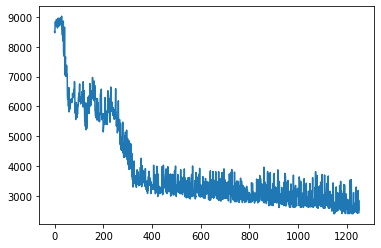

final distance is: 2388.0904658377617


In [28]:
#TO FILL

def optimize(initialPath, tStep=200, alpha=0.97,T=1000):
    distances = [getLength(initialPath)]
    paths = [initialPath]
    for t in np.arange(tStep):
        newPath = exchange(list(initialPath))
        
        oldD = getLength(initialPath)
        newD = getLength(newPath)
        
        if np.exp((oldD - newD)/temp(t,alpha,T)) > np.random.random():
            initialPath = newPath
        
        distances.append(newD)
        paths.append(newPath)
    
    return initialPath, distances


best, dist = optimize(getPath(len(capitals_list)), 1250, alpha=0.99,T=1000)

plt.plot(np.arange(len(dist)), dist)
plt.show()
#show_path(best, best[0])
#plt.show()
print("final distance is: {}".format(np.min(dist)))





















## Problem 6 : Local minima and searching


Now that the algorithm is set, we want to obtain the absolute best path for all cities. Repeat the simulated annealing 20 times with the optimal set of parameters that you have identified. 

Store for each attempt the best distance, and the optimal path. Propose a final solution to the problem, you can of course compare with the solutions obtained by other students.







lowest path is: 2184.624259039371


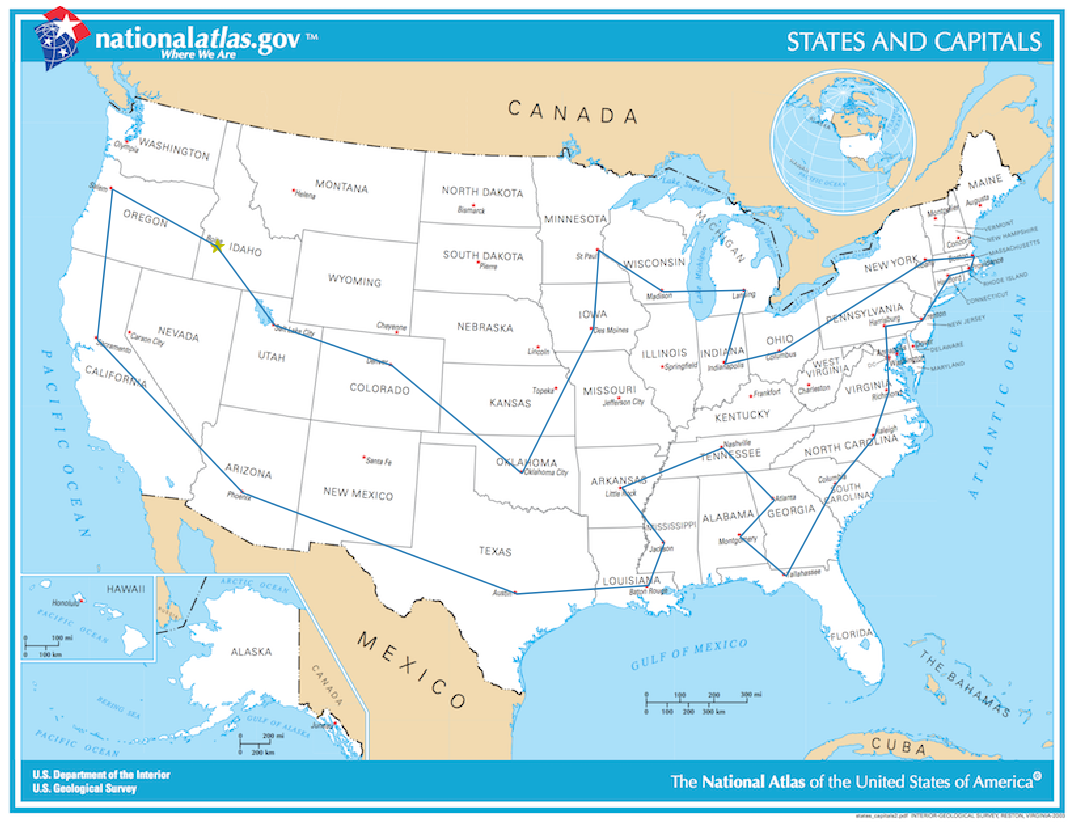

In [29]:
#TO FILL

def solvePath(path,iterN=20,alpha=0.95,T=1000):
    currentPath = [path]
    dist = getLength(path)
    for i in range(iterN):
        #print(dist)
        newPath, newDist = optimize(path, 1250,alpha=alpha, T=T)
        lowest = np.min(newDist[-200:])
        
        if lowest < dist:
            currentPath = newPath
            dist = lowest
    
    return currentPath, dist


path, dist = solvePath(getPath(len(capitals_list)), 40)

print("lowest path is: {}".format(dist))

show_path(path, path[0])
plt.show()
        




In [ ]:
for a in np.linspace(.9,.999,5):
    path, dist = solvePath(getPath(len(capitals_list)), 10, alpha=a)
    print("lowest path is: {0}, a is {1}".format(dist, a))
    


In [ ]:
import scipy.optimize as optim
initialPath = getPath(len(capitals_list))

func = lambda p: solvePath(initialPath, iterN=3, alpha=p[0], T=p[1])[1]

initialGuess = [0.97,1000]

best = optim.minimize(func,initialGuess, options={"maxiter":1})
print(best.x)

lowest path is: 2503.446674720074


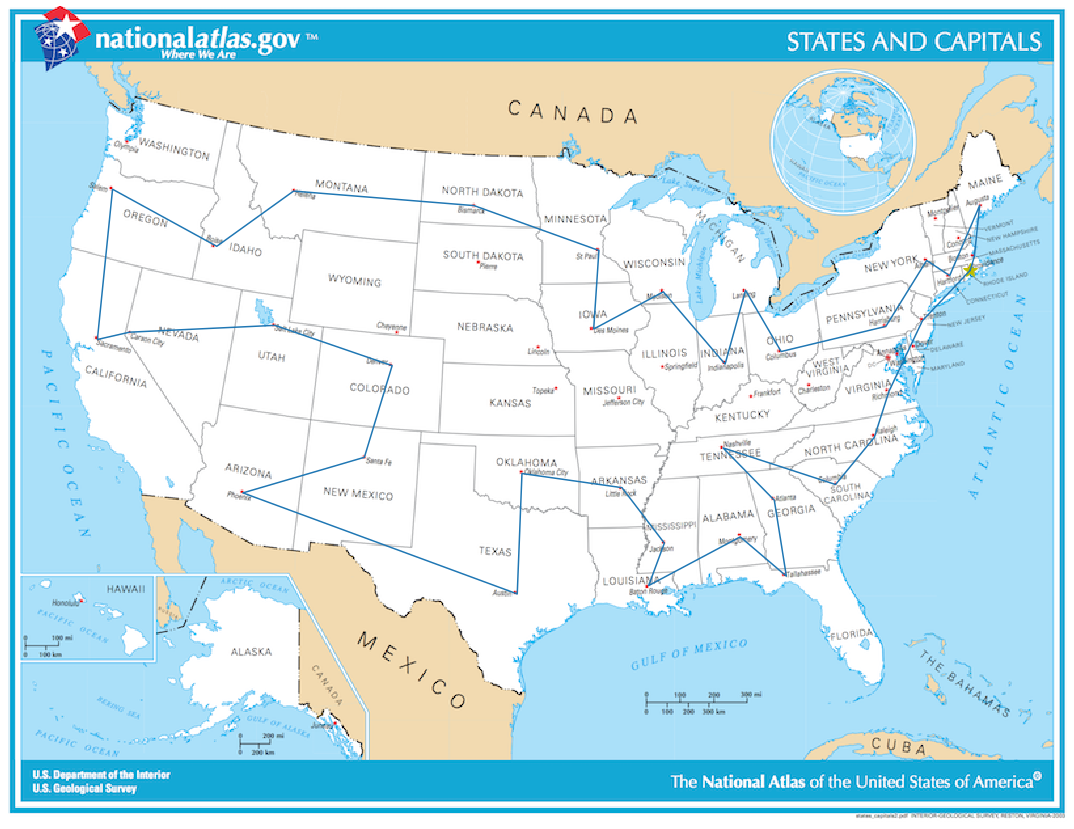

In [30]:
new = [("Bismark", (356.2,151.7)),("Helena", (218.3,140.6)),("Santa Fe", (272.4,344)),("Augusta", (742.5,151.6)),("Carson City", (93,248.4))]

truePath = getPath(len(capitals_list))
truePath.extend(new)


path, dist = solvePath(truePath, 80)

print("lowest path is: {}".format(dist))

show_path(path, path[0])
plt.show()


## Open questions

We propose here a set of open-ended questions, which will provide opportunities to expand the discussion in your report. 


0. How can you find the longest path instead of the shortest path, explain your idea

0. Explain why the cooling procedure and temperature schedule is key to the success of the minimisation

0. Imagine that we now slightly complicate the question: Travelling coast-to-coast is difficult in winter time, due to frequent road closures in the central states (snow conditions). How could you modify the algorithm such that we avoid as much as possible crossing the country transversally ?

0. Comment briefly on possible other scientific topics where simulated annealing could be useful, and provide one or two references

Share and discuss your results with others in the class !

 


Answers : 
    
    
    .......
    
    
    .......
    
    
    .......